<a href="https://colab.research.google.com/github/ShahdTarek/102_Flower_Classification/blob/main/Oxford_102Flowers_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>





> # Libraries





In [1]:
!pip install tensorflow scikit-learn


In [44]:
import os
import sys
import PIL
import json
import cv2
import scipy.io
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
from google.colab import drive
from tqdm.notebook import tqdm
from collections import Counter
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.utils import to_categorical

> #  Preprocessing

In [4]:
directory_name = 'Data'

os.makedirs(directory_name, exist_ok=True)

drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
img_labels = scipy.io.loadmat("/content/drive/MyDrive/ASDC/Task_2/102Flowers/imagelabels.mat")
img_labels = img_labels["labels"]
img_labels = img_labels[0]

for i in range(len(img_labels)):
  img_labels[i] = img_labels[i] - 1

df = pd.DataFrame({'label':img_labels})
df

,label
0,76
1,76
2,76
3,76
4,76
...,...
8184,61
8185,61
8186,61
8187,61


In [8]:
folder_path = '/content/drive/MyDrive/ASDC/Task_2/102Flowers/jpg'

# Get the list of file names in the folder
file_names = os.listdir(folder_path)

# Extract labels from file names based on the sequence
labels = [file.split('_')[0] for file in file_names]

df = pd.DataFrame({'Image': file_names, 'label':df['label']})


df


,Image,label
0,image_07206.jpg,76
1,image_07321.jpg,76
2,image_07190.jpg,76
3,image_07302.jpg,76
4,image_07212.jpg,76
...,...,...
8184,image_00113.jpg,61
8185,image_00134.jpg,61
8186,image_00066.jpg,61
8187,image_00046.jpg,61


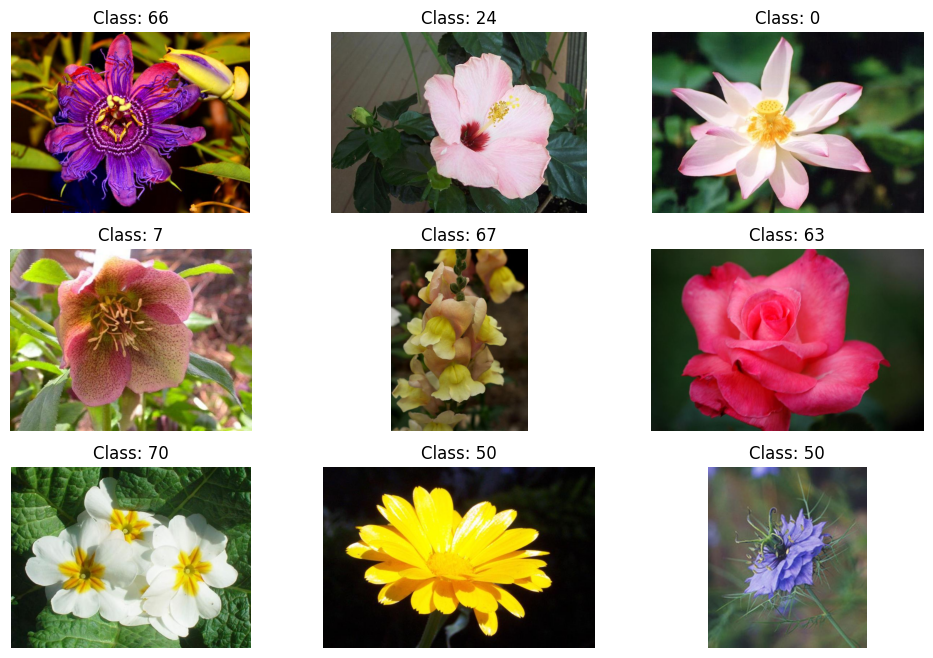

In [10]:
plt.figure(figsize=(12,8))

random_image = df.sample(n=9)
random_image_paths = random_image['Image'].values
random_image_cat = random_image['label'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open('/content/drive/MyDrive/ASDC/Task_2/102Flowers/jpg/'+path)
    plt.subplot(3,3, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')
plt.show()

In [45]:
df3 = df.copy()

In [46]:
X = []
y = []
for image, label in tqdm(zip(df3.Image.values, df3.label.values), total=len(df3)):
    try:
        xt = np.array(Image.open(os.path.join('/content/drive/MyDrive/ASDC/Task_2/102Flowers/jpg/', image)).resize((128,128)))
        yt = label
        X.append(xt)
        y.append(yt)
    except:
        print(os.path.join('/content/drive/MyDrive/ASDC/Task_2/102Flowers/jpg/', image))

X = np.array(X)
y = np.array(y)

print(X.shape, y.shape)


  0%|          | 0/8189 [00:00<?, ?it/s]

(8189, 128, 128, 3) (8189,)




> # Data Spliting



In [47]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.1)
train_y = to_categorical(train_y)
test_y = to_categorical(test_y)

print(train_y.shape, test_y.shape)

(7370, 102) (819, 102)


In [48]:
print(train_X.shape, train_y.shape)

(7370, 128, 128, 3) (7370, 102)




> # Visualization



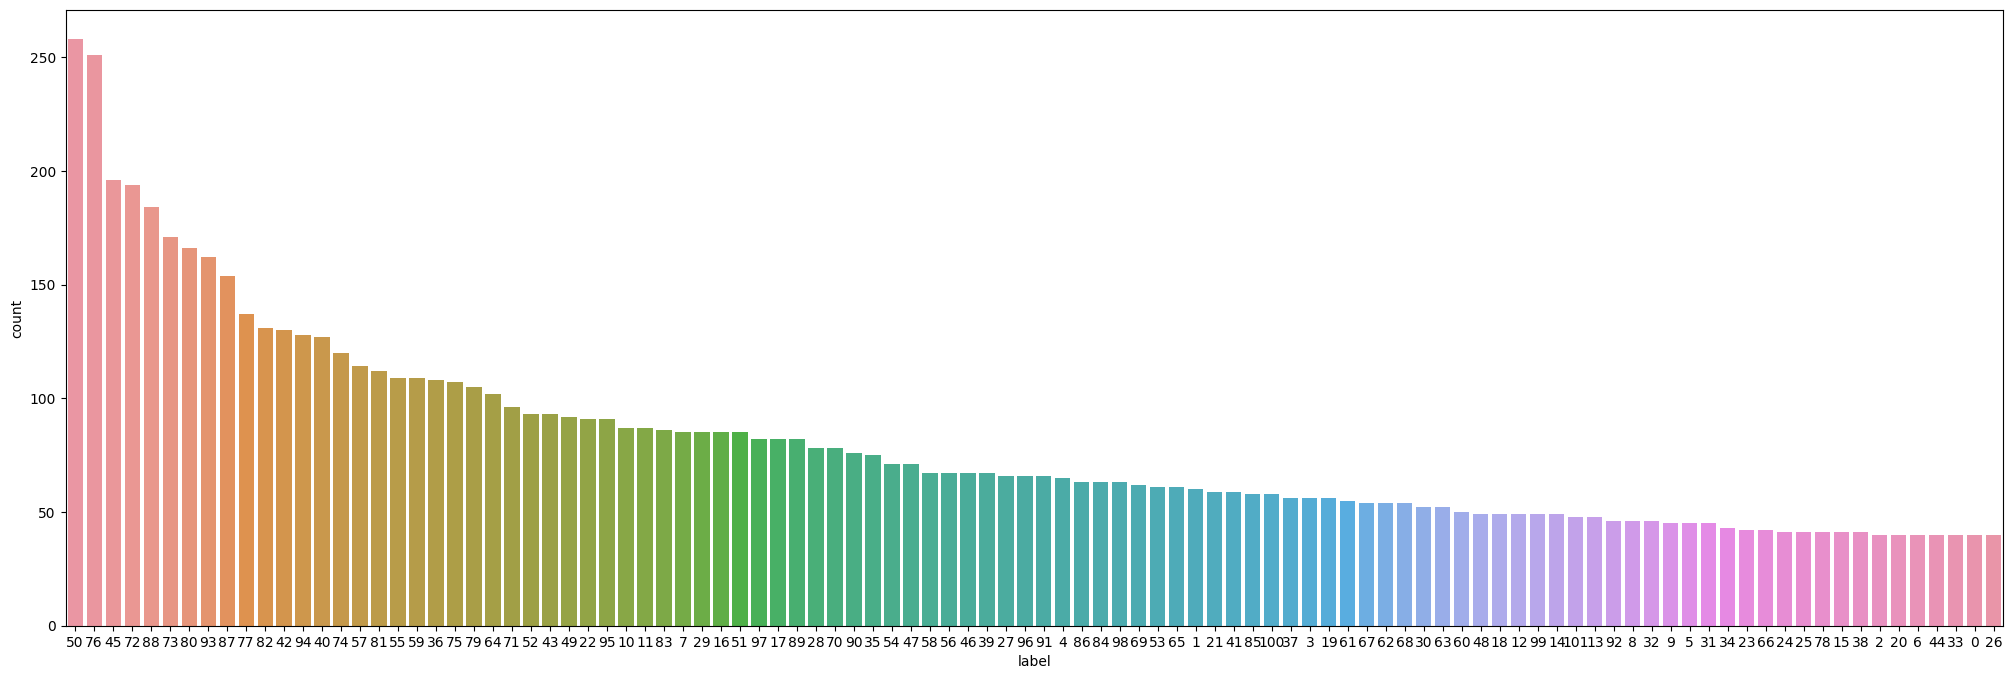

In [49]:
plt.figure(figsize=(25, 8))
sns.countplot(data=df, x='label', order=df['label'].value_counts().index)

plt.show()

In [50]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.2,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest')

img = load_img(os.path.join('/content/drive/MyDrive/ASDC/Task_2/102Flowers/jpg/','image_00001.jpg'))  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir="Data", save_prefix='f', save_format='jpg'):
    i += 1
    if i > 20:
        break




> # CNN



In [51]:
model = Sequential()
model.add(Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=(128, 128, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(102, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 16, 16, 64)       

In [52]:
batch_size = 16

# Augmentation configuration for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.1,
        horizontal_flip=True)

# Augmentation configuration for testing
test_datagen = ImageDataGenerator(rescale=1./255)

In [53]:
train_generator = train_datagen.flow(
        train_X,
        train_y,
        batch_size=batch_size,
        shuffle=True
        )

validation_generator = test_datagen.flow(
        test_X,
        test_y,
        shuffle=False,
        )



> # Training



In [54]:
history = model.fit(
        train_generator,
        epochs=100,
        validation_data=validation_generator)

Epoch 1/100
461/461 [==============================] - 41s 81ms/step - loss: 4.4968 - accuracy: 0.0339 - val_loss: 4.3669 - val_accuracy: 0.0391
Epoch 2/100
461/461 [==============================] - 43s 94ms/step - loss: 4.3170 - accuracy: 0.0529 - val_loss: 4.2371 - val_accuracy: 0.0708
Epoch 3/100
461/461 [==============================] - 38s 83ms/step - loss: 4.1791 - accuracy: 0.0676 - val_loss: 4.0888 - val_accuracy: 0.0855
Epoch 4/100
461/461 [==============================] - 40s 86ms/step - loss: 4.0628 - accuracy: 0.0794 - val_loss: 4.0080 - val_accuracy: 0.0806
Epoch 5/100
461/461 [==============================] - 37s 80ms/step - loss: 3.9270 - accuracy: 0.0953 - val_loss: 3.9331 - val_accuracy: 0.1074
Epoch 6/100
461/461 [==============================] - 38s 81ms/step - loss: 3.8038 - accuracy: 0.1155 - val_loss: 3.7701 - val_accuracy: 0.1233
Epoch 7/100
461/461 [==============================] - 46s 100ms/step - loss: 3.6628 - accuracy: 0.1267 - val_loss: 3.6993 - val_a



> # Model saving



In [57]:
model.save('/content/drive/MyDrive/ASDC/Task_2/102Flowers/flower_classification_model.hdf5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(




> # Predictions



In [98]:
from keras.models import load_model
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from IPython.display import Image, display
import numpy as np


cnn_model = load_model('/content/drive/MyDrive/ASDC/Task_2/102Flowers/flower_classification_model.hdf5')


In [94]:
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(128, 128))  # Adjust target size based on your model's input size
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array


In [69]:
Labels_dic = {"21": "fire lily", "3": "canterbury bells", "45": "bolero deep blue", "1": "pink primrose", "34": "mexican aster", "27": "prince of wales feathers", "7": "moon orchid", "16": "globe-flower", "25": "grape hyacinth", "26": "corn poppy", "79": "toad lily", "39": "siam tulip", "24": "red ginger", "67": "spring crocus", "35": "alpine sea holly", "32": "garden phlox", "10": "globe thistle", "6": "tiger lily", "93": "ball moss", "33": "love in the mist", "9": "monkshood", "102": "blackberry lily", "14": "spear thistle", "19": "balloon flower", "100": "blanket flower", "13": "king protea", "49": "oxeye daisy", "15": "yellow iris", "61": "cautleya spicata", "31": "carnation", "64": "silverbush", "68": "bearded iris", "63": "black-eyed susan", "69": "windflower", "62": "japanese anemone", "20": "giant white arum lily", "38": "great masterwort", "4": "sweet pea", "86": "tree mallow", "101": "trumpet creeper", "42": "daffodil", "22": "pincushion flower", "2": "hard-leaved pocket orchid", "54": "sunflower", "66": "osteospermum", "70": "tree poppy", "85": "desert-rose", "99": "bromelia", "87": "magnolia", "5": "english marigold", "92": "bee balm", "28": "stemless gentian", "97": "mallow", "57": "gaura", "40": "lenten rose", "47": "marigold", "59": "orange dahlia", "48": "buttercup", "55": "pelargonium", "36": "ruby-lipped cattleya", "91": "hippeastrum", "29": "artichoke", "71": "gazania", "90": "canna lily", "18": "peruvian lily", "98": "mexican petunia", "8": "bird of paradise", "30": "sweet william", "17": "purple coneflower", "52": "wild pansy", "84": "columbine", "12": "colt's foot", "11": "snapdragon", "96": "camellia", "23": "fritillary", "50": "common dandelion", "44": "poinsettia", "53": "primula", "72": "azalea", "65": "californian poppy", "80": "anthurium", "76": "morning glory", "37": "cape flower", "56": "bishop of llandaff", "60": "pink-yellow dahlia", "82": "clematis", "58": "geranium", "75": "thorn apple", "41": "barbeton daisy", "95": "bougainvillea", "43": "sword lily", "83": "hibiscus", "78": "lotus lotus", "88": "cyclamen", "94": "foxglove", "81": "frangipani", "74": "rose", "89": "watercress", "73": "water lily", "46": "wallflower", "77": "passion flower", "51": "petunia"}

Labels = pd.DataFrame(list(Labels_dic.items()), columns=['label', 'name'])

In [70]:
Labels

,label,name
0,21,fire lily
1,3,canterbury bells
2,45,bolero deep blue
3,1,pink primrose
4,34,mexican aster
...,...,...
97,89,watercress
98,73,water lily
99,46,wallflower
100,77,passion flower


1/1 [==============================] - 0s 92ms/step
Predicted Flower specie is :  fire lily
With Label :  21


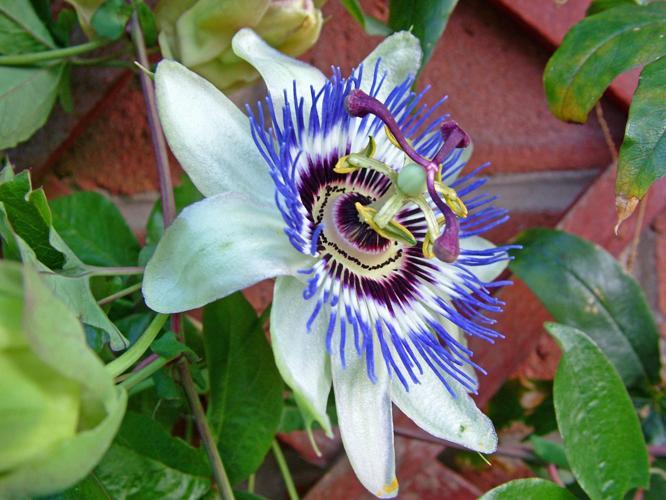

In [99]:
new_image_path = '/content/drive/MyDrive/ASDC/Task_2/102Flowers/jpg/image_00013.jpg'
preprocessed_image = preprocess_image(new_image_path)

# Make prediction
predictions = cnn_model.predict(preprocessed_image)

class_labels = df['label'].unique()

# Predicted class index
predicted_class_index = np.argmax(predictions)
predicted_class_label = class_labels[predicted_class_index]
predicted_name = Labels.loc[Labels['label'] == str(predicted_class_label), 'name'].values[0]

print("Predicted Flower specie is : ", predicted_name)
print('With Label : ', predicted_class_label)

display(Image(filename=new_image_path))

1/1 [==============================] - 0s 39ms/step
Predicted Flower specie is :  windflower
With Label :  69


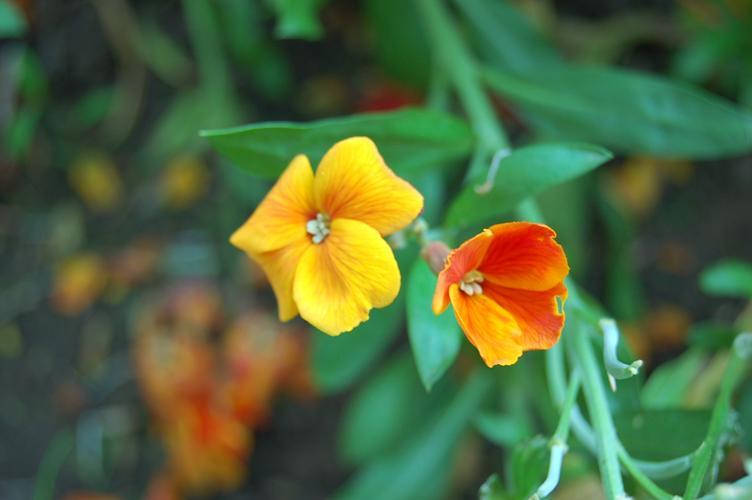

In [102]:
new_image_path = '/content/drive/MyDrive/ASDC/Task_2/102Flowers/jpg/image_01050.jpg'
preprocessed_image = preprocess_image(new_image_path)

# Make prediction
predictions = cnn_model.predict(preprocessed_image)

class_labels = df['label'].unique()

# Predicted class index
predicted_class_index = np.argmax(predictions)
predicted_class_label = class_labels[predicted_class_index]
predicted_name = Labels.loc[Labels['label'] == str(predicted_class_label), 'name'].values[0]

print("Predicted Flower specie is : ", predicted_name)
print('With Label : ', predicted_class_label)

display(Image(filename=new_image_path))

1/1 [==============================] - 0s 32ms/step
Predicted Flower specie is :  gazania
With Label :  71


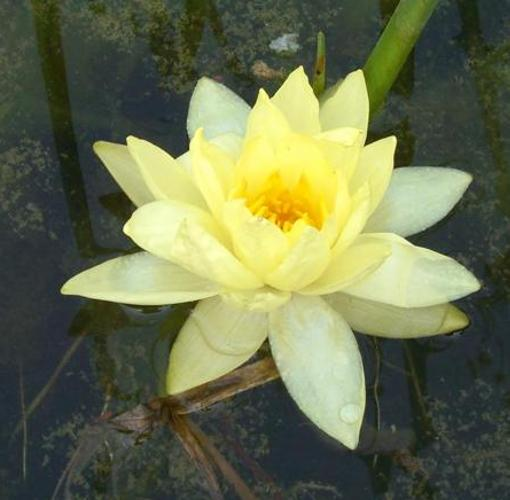

In [103]:
new_image_path = '/content/drive/MyDrive/ASDC/Task_2/102Flowers/jpg/image_00307.jpg'
preprocessed_image = preprocess_image(new_image_path)

# Make prediction
predictions = cnn_model.predict(preprocessed_image)

class_labels = df['label'].unique()

# Predicted class index
predicted_class_index = np.argmax(predictions)
predicted_class_label = class_labels[predicted_class_index]
predicted_name = Labels.loc[Labels['label'] == str(predicted_class_label), 'name'].values[0]

print("Predicted Flower specie is : ", predicted_name)
print('With Label : ', predicted_class_label)

display(Image(filename=new_image_path))